In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from numba import jit
from matplotlib_scalebar.scalebar import ScaleBar
path_figs = 'Figs/'

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.8
memory_drift_adaptive_coef = 0
visual_drift_adaptive_coef = 0
# memory_drift_adaptive_coef_activation = 0.3
# memory_drift_adaptive_coef_deactivation = 0.9

memory_drift_adaptive_coef_activation = 0
memory_drift_adaptive_coef_deactivation = 0

In [2]:
custom_palette = {
    'M': sns.color_palette('colorblind')[0],
    'S': sns.color_palette('colorblind')[7],
    'M+S': sns.color_palette('colorblind')[1],
    'M+S (changed)': sns.color_palette('colorblind')[3]
}


In [3]:
finger_colors = {
    'S': sns.color_palette('colorblind')[0],
    'M': sns.color_palette('colorblind')[5],
    'other': 'black'
}
finger_alphas = {
    'S': 1,
    'M': 1,
    'other': 0.5
}

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 8.5, "1.5col": 11.6, "2col": 17.6}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    # rcParams["font.size"] = 10  # General font size
    rcParams["font.size"] = 20  # General font size
    # rcParams["axes.titlesize"] = 12  # Figure title
    rcParams["axes.titlesize"] = 26  # Figure title
    # rcParams["axes.labelsize"] = 9  # Axis main label
    rcParams["axes.labelsize"] = 22  # Axis main label
    # rcParams["xtick.labelsize"] = 7  # Tick labels
    rcParams["xtick.labelsize"] = 16  # Tick labels
    # rcParams["ytick.labelsize"] = 7
    rcParams["ytick.labelsize"] = 16
    # rcParams["legend.fontsize"] = 8  # Legend entries
    rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    # rcParams["axes.linewidth"] = 0.75
    rcParams["axes.linewidth"] = 1.5

    rcParams["lines.linewidth"] = 3
    
    # rcParams["xtick.major.width"] = 0.75
    rcParams["xtick.major.width"] = 1.5
    # rcParams["ytick.major.width"] = 0.75
    rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")




In [5]:
# memory_drift_adaptive_coef_activation = 0
# memory_drift_adaptive_coef_deactivation = 0

In [6]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [7]:
seq = '1352423'
specific_seq = '1352423'
random_seq = '4534132'
# specific_seq_changed = '1352423'
specific_seq_changed_one_digit = '1353423'


seq_length = len(seq)
window_sizes = [1,2,3,7]


visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)


visual_delay = 90
motor_delay = 50

diffusion = 3
threshold = 310
alpha = 0.9985
# alpha = 0.9987
# alpha = 0.999
# beta = 0.0005
# beta = 0.001
# beta = 0.0001
# beta = 0
# beta = 0.0015
beta = 0.005

# param = [0.80456878, 0.36385731, 0.75921864, 0.36382248, 0.17006857,
#        0.72666298, 0.36340774, 0.16293408, 0.07705195]


# param = [0.81403939, 0.39269762, 0.78576587, 0.39263559, 0.1590846 ,
#        0.78171855, 0.39182347, 0.13888817, 0.05866263]


# param = [0.80546286, 0.34406671, 0.77078511, 0.34047097, 0.17400204,
#        0.76927114, 0.33807873, 0.16315422, 0.08028436]


# param = [0.75295921, 0.50182646, 0.73406735, 0.45987093, 0.34447993,
#         0.69723121, 0.41742494, 0.2493258 , 0.24174475]


param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]


# motor_planning_param = [0.54899844, 0.3728446 , 0.32852511]
# motor_planning_param = [0.7527961,  0.78437558, 0.16115195]
motor_planning_param = [0.78642621, 0.78482953, 0.16115546]
# motor_planning_param = [0.7, 0.69, 0.3]
# motor_planning_param = [0.7, 0.6, 0.3]
# motor_planning_param = [0.7, 0.5, 0.3]
# motor_planning_param = [0.7, 0.49, 0.29]
# motor_planning_param = [0.7, 0.47, 0.33]
# motor_planning_param = [0.7, 0.45, 0.35]
# motor_planning_param = [0.7, 0.1, 0.4]
# motor_planning_param [ 0.7, 1, 0, 0]

In [8]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")


@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

@jit(nopython=True)
def exp_motor_planning(capacity, param):
    theta = np.zeros(capacity)
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = 1 - theta[0]
    elif capacity >= 3:
        theta[0] = param[1]
        theta[1] = param[2]
        theta[2] = 1 - theta[0] - theta[1]
    # elif capacity >= 4:
    #     theta[0] = param[3]
    #     theta[1] = param[4]
    #     theta[2] = param[5]
    #     theta[3] = 1 - theta[0] - theta[1] - theta[2]
        
    return theta

def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])


def changed_digit_idx(seq1, seq2):
    """
    Find the index of the first digit that differs between two sequences.
    
    Parameters:
        seq1 (str): The first sequence.
        seq2 (str): The second sequence.
        
    Returns:
        int: The index of the first differing digit, or -1 if they are identical.
    """
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            return i
    return -1

In [14]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, motor_planning_param , planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    # effective_planning_capacity_motor = 0
    effective_planning_capacity_motor = planning_capacity
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
    motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        # evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]
        evidence[:, current_press_planned: current_press_planned + 1] += diffusion_term * random_terms[:, current_press_planned: current_press_planned + 1, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef

        for press in range(current_press_planned, min(seq_length, current_press_planned + effective_planning_capacity_motor)):
            evidence[:, press] += motor_planning_coefs[press - current_press_planned] * drifts_memory_dt[:, press] * current_memory_coef
            

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            


        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            # effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = planning_capacity
            try:
                planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            
            except:
                # print("current press planned", current_press_planned)
                # print("Time", time)
                # print("press times", press_times)
                return press_times, evidence
                # pass
            
            # planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            # effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = planning_capacity
            try:
                planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            
            except:
                # print("****** this type *********")
                # print("current press planned", current_press_planned)
                # print("Time", time)
                # print("press times", press_times)
                return press_times, evidence
            # planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




    return press_times, evidence

In [15]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3, motor_planning_param = 3, 
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.motor_planning_param = motor_planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drifts_coef = memory_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, self.motor_planning_param,
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drifts_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for a simulation
        """ 
        
        # fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        # fig , axs = plt.subplots(1, self.seq_length)
        fig , axs = plt.subplots(1, 4, figsize=(10,2))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        # effective_planning_capacity_motor = 0
        effective_planning_capacity_motor = self.planning_capacity
        visible_window_size = 0

        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, self.motor_planning_param)


        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 

            for press in range(current_press_planned, min(self.seq_length, current_press_planned + effective_planning_capacity_motor)):
                for finger in range(5):
                    evidence[finger, press] += motor_planning_coefs[press - current_press_planned] * self.memory_drifts[finger, press] * self.dt * current_memory_coef

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

            for press in range(0, self.seq_length):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]



            if (evidence[: , current_press_planned:current_press_planned + 1] >= self.threshold).any():
                visible_window_size -= 1
                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                # effective_planning_capacity_motor = min(self.seq_length - current_press_planned, self.planning_capacity)
                effective_planning_capacity_motor = self.planning_capacity
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, self.motor_planning_param)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                # print("current memory: ", current_memory_coef)
                # print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                # effective_planning_capacity_motor = min(self.seq_length - current_press_planned, self.planning_capacity)
                effective_planning_capacity_motor = self.planning_capacity
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
                motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, self.motor_planning_param)

            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        # for press in range(self.seq_length):
        for press in range(4):
            print(press_times[press])
            for finger in range(5):
                if (self.seq[press] == str(finger + 1)):
                    finger_condition = 'S'
                else:
                    finger_condition = 'other'
                # axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}', 
                #                 color = finger_colors[finger_condition], alpha = finger_alphas[finger_condition])
                axs[press].plot(np.arange(0, np.round(press_times[0], 2), self.dt)[:-motor_delay], 
                                evidence_over_time[finger, press, :int(press_times[0]) - motor_delay], label = f'Finger {finger+1}', 
                                color = finger_colors[finger_condition], alpha = finger_alphas[finger_condition])
            # axs[press].set_xlim([0, np.round(time, 2)])                            
            # axs[press].set_xlim([0, np.round(press_times[0], 2)])
            axs[press].axhline(y = self.threshold, color = 'black', linestyle = '--', label = 'Threshold')
            # axs[press].set_xlabel('Time (a.u.)')
            # axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            # axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))
            

            # axs[press].set_title(f'Press {press + 1}')

        fig.supxlabel('Time (a.u.)')
        fig.supylabel('Evidence (a.u.)')
        return fig, axs
    





    def plot_average_simulations(self, num_simulations):
        """
        Plot the average evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        changed_digit = changed_digit_idx(self.seq, self.specific_seq)
        print("changed digit: ", changed_digit)

        # fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        all_evidence = np.zeros((num_simulations, 5, self.seq_length, int(self.max_time/self.dt)))


        for _ in range(num_simulations):
            evidence = np.zeros((5, self.seq_length))
            evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
            time = 0
            t_index = 0
            visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
            motor_delay_queue = np.array([], dtype=float)
            current_press_planned = 0
            current_press_execed = 0

            current_memory_coef = memory_drift_coef
            current_visual_coef = visual_drift_coef

            effective_planning_capacity = 0
            # effective_planning_capacity_motor = 0
            effective_planning_capacity_motor = self.planning_capacity
            visible_window_size = 0

            planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, self.motor_planning_param)


            press_times = np.full(seq_length, np.nan)
            press_times_index = np.full(seq_length, np.nan)
            A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

            total_steps = int(self.max_time / self.dt)

            random_terms = np.random.randn(5, seq_length ,total_steps)

            while time < self.max_time - self.dt:
                time += self.dt
                t_index += 1
                visual_delay_queue += self.dt
                if len(motor_delay_queue) > 0:
                    motor_delay_queue[0] += self.dt

                evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
                evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
                evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]
                # evidence_over_time[:, :, t_index] = evidence[:, :]

                for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                    for finger in range(5):
                        evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 

                for press in range(current_press_planned, min(self.seq_length, current_press_planned + effective_planning_capacity_motor)):
                    for finger in range(5):
                        evidence[finger, press] += motor_planning_coefs[press - current_press_planned] * self.memory_drifts[finger, press] * self.dt * current_memory_coef

                evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])

                for press in range(0, self.seq_length):
                    for finger in range(5):
                        evidence_over_time[finger, press, t_index] = evidence[finger, press]



                if (evidence[: , current_press_planned:current_press_planned + 1] >= self.threshold).any():
                    visible_window_size -= 1
                    current_press_planned += 1
                    motor_delay_queue = np.append(motor_delay_queue, 0)
                    effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                    # effective_planning_capacity_motor = min(self.seq_length - current_press_planned, self.planning_capacity)
                    effective_planning_capacity_motor = self.planning_capacity
                    planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                    motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, self.motor_planning_param)
                
                if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                    motor_delay_queue = motor_delay_queue[1:]
                    visual_delay_queue = np.append(visual_delay_queue, 0)
                    press_times[current_press_execed] = time
                    press_times_index[current_press_execed] = t_index

                    if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                        current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                        current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                    else:
                        current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                        current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

                    current_press_execed += 1

                    if current_press_planned == self.seq_length:
                        break

                visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
                pass_count = sum(visual_delay_passed_mask)
                if pass_count > 0:
                    visible_window_size += pass_count
                    visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                    effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                    # effective_planning_capacity_motor = min(self.seq_length - current_press_planned, self.planning_capacity)
                    effective_planning_capacity_motor = self.planning_capacity
                    planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
                    motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, self.motor_planning_param)
            
            # set evidence after hitting the threshold to 1
            evidence_over_time[int(self.specific_seq[changed_digit]), changed_digit, int(press_times_index[changed_digit]):] = self.threshold
            all_evidence[_, :, :, :] = evidence_over_time


        evidence_over_time = np.mean(all_evidence, axis = 0)

        
        # for press in range(self.seq_length):
        for press in [changed_digit]:
            for finger in range(5):
                if (self.seq[press] == str(finger + 1)):
                    finger_condition = 'S'
                elif (self.specific_seq[press] == str(finger + 1)): 
                    finger_condition = 'M'
                else:
                    finger_condition = 'other'
                # axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}',
                #                 color = finger_colors[finger_condition], alpha = finger_alphas[finger_condition])

                # plt.plot(np.arange(0, np.round(press_times[changed_digit], 2), self.dt), 
                #          evidence_over_time[finger, press, :int(press_times[changed_digit])], label = f'Finger {finger+1}',
                #                 color = finger_colors[finger_condition], alpha = finger_alphas[finger_condition])
                
                plt.plot(np.arange(0, np.round(self.max_time, 2), self.dt), 
                         evidence_over_time[finger, press, :int(self.max_time)], label = f'Finger {finger+1}',
                                color = finger_colors[finger_condition], alpha = finger_alphas[finger_condition])
                
            # axs[press].set_xlim([0, np.round(time, 2)])
            # plt.xlim([0, np.round(press_times[0], 2)])
            # axs[press].axhline(y = self.threshold, color = 'black', linestyle = '--', label = 'Threshold')
            # plt.axhline(y = self.threshold, color = 'black', linestyle = '--', label = 'Threshold')
            # axs[press].set_xlabel('Time')
            plt.xlabel('Time (a.u.)')
            # axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            # axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            # axs[press].set_title(f'Press {press + 1}')

        # fig.supylabel('Evidence')
        # return fig, axs
    

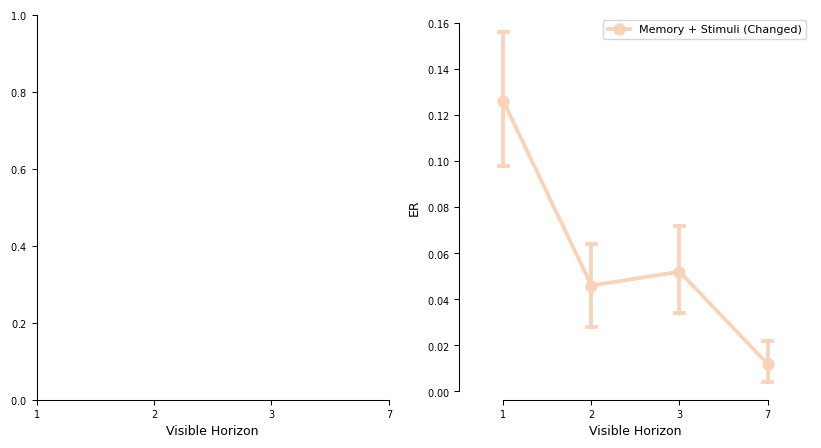

CPU times: user 16.1 s, sys: 28.1 ms, total: 16.1 s
Wall time: 16.2 s


In [1448]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

fig, axs = plt.subplots(1,2, figsize = (10,5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 500
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq_changed_one_digit):
                # if (np.isnan(IPIs).any()):
                #     print('nan')
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[1])


for ax in axs:
    ax.set_xlabel('Visible Horizon')
    ax.set_xticks(range(len(window_sizes)))
    ax.set_xticklabels(window_sizes)


# legend labels

plt.legend(loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_79805/2296344781.py:47: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]


Visual Delay: 0, Window Size: 1, #correct: 500
Visual Delay: 0, Window Size: 2, #correct: 500
Visual Delay: 0, Window Size: 3, #correct: 500
Visual Delay: 0, Window Size: 7, #correct: 500
Visual Delay: 50, Window Size: 1, #correct: 500
Visual Delay: 50, Window Size: 2, #correct: 500
Visual Delay: 50, Window Size: 3, #correct: 500
Visual Delay: 50, Window Size: 7, #correct: 500
Visual Delay: 100, Window Size: 1, #correct: 500
Visual Delay: 100, Window Size: 2, #correct: 500
Visual Delay: 100, Window Size: 3, #correct: 500
Visual Delay: 100, Window Size: 7, #correct: 500
Visual Delay: 150, Window Size: 1, #correct: 500
Visual Delay: 150, Window Size: 2, #correct: 500
Visual Delay: 150, Window Size: 3, #correct: 500
Visual Delay: 150, Window Size: 7, #correct: 500
Visual Delay: 200, Window Size: 1, #correct: 500
Visual Delay: 200, Window Size: 2, #correct: 500
Visual Delay: 200, Window Size: 3, #correct: 500
Visual Delay: 200, Window Size: 7, #correct: 500


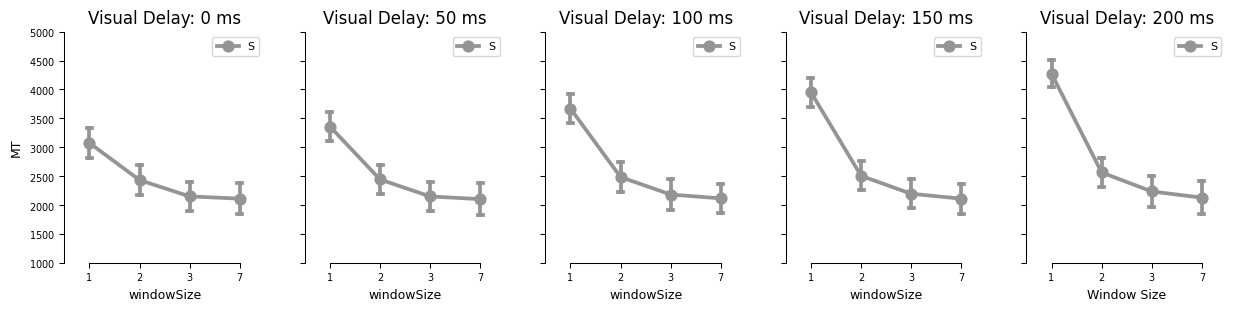

CPU times: user 1min 22s, sys: 1.13 s, total: 1min 23s
Wall time: 1min 25s


In [64]:
%%time 
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}
# kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': sns.color_palette('pastel')[0], 'alpha': 1}}
visual_delays = [0, 50, 100, 150, 200]

fig, axs = plt.subplots(1, len(visual_delays), figsize = (15, 3), sharey = True)

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
for idx, visual_delay in enumerate(visual_delays):
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    num_sims = 500
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
        threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, 
        planning_capacity=3, planning_param=param, motor_planning_param = motor_planning_param,
        alpha = alpha, beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)]= [window, sum(IPIs[1:])]

        print(f"Visual Delay: {visual_delay}, Window Size: {window}, #correct: {len(MT[MT['windowSize'] == window])}")

    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'S', capsize=0.1, color = custom_palette['S'], ax = axs[idx])
    axs[idx].set_title(f"Visual Delay: {visual_delay} ms")
    axs[idx].set_xticks(range(len(window_sizes)), window_sizes)

# plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Window Size')
plt.ylabel('Movement Time (a.u.)')
plt.ylim([1000, 5000])
sns.despine(trim=True)
plt.show()


******* Stimuli ********
800
******* Memory + Stimuli********


<timed exec>:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


800
******* Memory + Stimuli (Changed) ********
CPU times: user 29.6 s, sys: 71.2 ms, total: 29.7 s
Wall time: 29.4 s


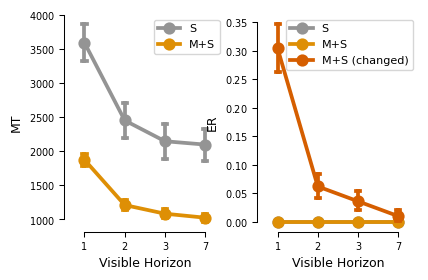

In [1459]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

set_figure_style("1.5col")

fig, axs = plt.subplots(1,2)


ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
print("******* Stimuli ********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
        
print(len(ER))
sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, capsize=0.1, ax = axs[1], color = custom_palette[label])
sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, ax = axs[0], color = custom_palette[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 200
print("******* Memory + Stimuli********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

print(len(ER))

sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, capsize=0.1, ax = axs[1], color = custom_palette[label])
sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, ax = axs[0], color = custom_palette[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S (changed)'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 500
print("******* Memory + Stimuli (Changed) ********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, capsize=0.1, ax = axs[1], color = custom_palette[label])



# model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

for ax in axs:
    ax.set_xlabel('Visible Horizon')
    ax.set_xticks(range(len(window_sizes)))
    ax.set_xticklabels(window_sizes)


# # legend labels

# plt.legend(loc='upper right')

# # plt.legend()
sns.despine(trim=True)
plt.savefig(path_figs + "MT_Capacity_Expansion.pdf", format = 'pdf', bbox_inches = 'tight')
# plt.show()


******* Stimuli ********
800
******* Memory + Stimuli********


<timed exec>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


800
******* Memory + Stimuli (Changed) ********


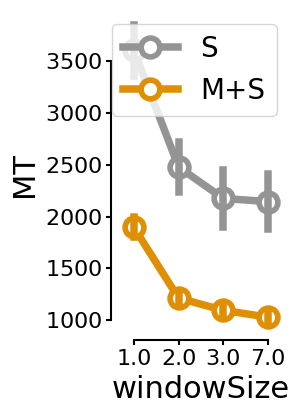

CPU times: user 27.5 s, sys: 413 ms, total: 27.9 s
Wall time: 27.6 s


In [66]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

# set_figure_style("1.5col")

set_figure_style("2col")

# fig, axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(fig.get_size_inches()[0]/3, fig.get_size_inches()[1] * 3 / 3)



ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
print("******* Stimuli ********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
        
print(len(ER))
# sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, capsize=0.1, ax = axs[1], color = custom_palette[label])
sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, color = custom_palette[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 200
print("******* Memory + Stimuli********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

print(len(ER))

# sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, capsize=0.1, ax = axs[1], color = custom_palette[label])
sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, color = custom_palette[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S (changed)'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 500
print("******* Memory + Stimuli (Changed) ********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
# sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, capsize=0.1, ax = axs[1], color = custom_palette[label])



# model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

# for ax in axs:
#     ax.set_xlabel('Visible Horizon')
#     ax.set_xticks(range(len(window_sizes)))
#     ax.set_xticklabels(window_sizes)

# plt.ylim([1000, 4200])
# # legend labels

# plt.legend(loc='upper right')

# # plt.legend()

# get current figure


for artist in plt.gcf().findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('white')

sns.despine(trim=True)
plt.savefig(path_figs + "MT_Capacity_Expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


******* Stimuli ********
800
******* Memory + Stimuli********


<timed exec>:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


800
******* Memory + Stimuli (Changed) ********


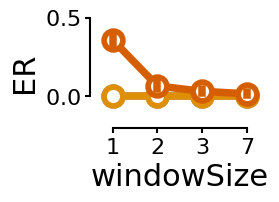

CPU times: user 27.5 s, sys: 434 ms, total: 27.9 s
Wall time: 27.8 s


In [67]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols
trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)

# set_figure_style("1.5col")


set_figure_style(scale="2col")

fig = plt.gcf()
fig.set_size_inches(fig.get_size_inches()[0]/3, fig.get_size_inches()[1]/3)

# #get height of figure
# fig = plt.figure()
# fig.canvas.draw()
# fig_height = fig.get_figheight()
# fig_width = fig.get_figwidth()
# fig.clear()
# plt.close(fig)

# fig = plt.figure(figsize=(fig_width, fig_height/2))

# fig, axs = plt.subplots(1,2)


ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
print("******* Stimuli ********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
        
print(len(ER))
sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, color = custom_palette[label], legend=False)
# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, color = custom_palette[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 200
print("******* Memory + Stimuli********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

print(len(ER))

sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, color = custom_palette[label], legend=False)
# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, color = custom_palette[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S (changed)'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
ER = pd.DataFrame(columns = ['windowSize', 'ER'])
num_sims = 500
print("******* Memory + Stimuli (Changed) ********")
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = label, color = custom_palette[label], legend=False)



# model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

# for ax in axs:
#     ax.set_xlabel('Visible Horizon')
#     ax.set_xticks(range(len(window_sizes)))
#     ax.set_xticklabels(window_sizes)


# # legend labels

# plt.legend(loc='upper right')

# # plt.legend()

for artist in plt.gcf().findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('white')

plt.ylim([-0.2, 0.5])
sns.despine(trim=True)
plt.savefig(path_figs + "ER_Capacity_Expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


In [1090]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols


trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
ER = pd.DataFrame(columns = ['windowSize', 'pressError'])
num_sims = 500
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        if ~(np.isnan(IPIs).any()):
            for press in range(len(seq)):
                if ~(np.argmax(evidence[:, press]) + 1 == int(specific_seq_changed_one_digit[press])):
                    ER.loc[len(ER)] = [window, press]
                    break




CPU times: user 14.9 s, sys: 18.5 ms, total: 14.9 s
Wall time: 15 s


In [1091]:
ER

,windowSize,pressError
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3
...,...,...
558,2,3
559,3,3
560,3,3
561,3,3


# Testing for different Betas

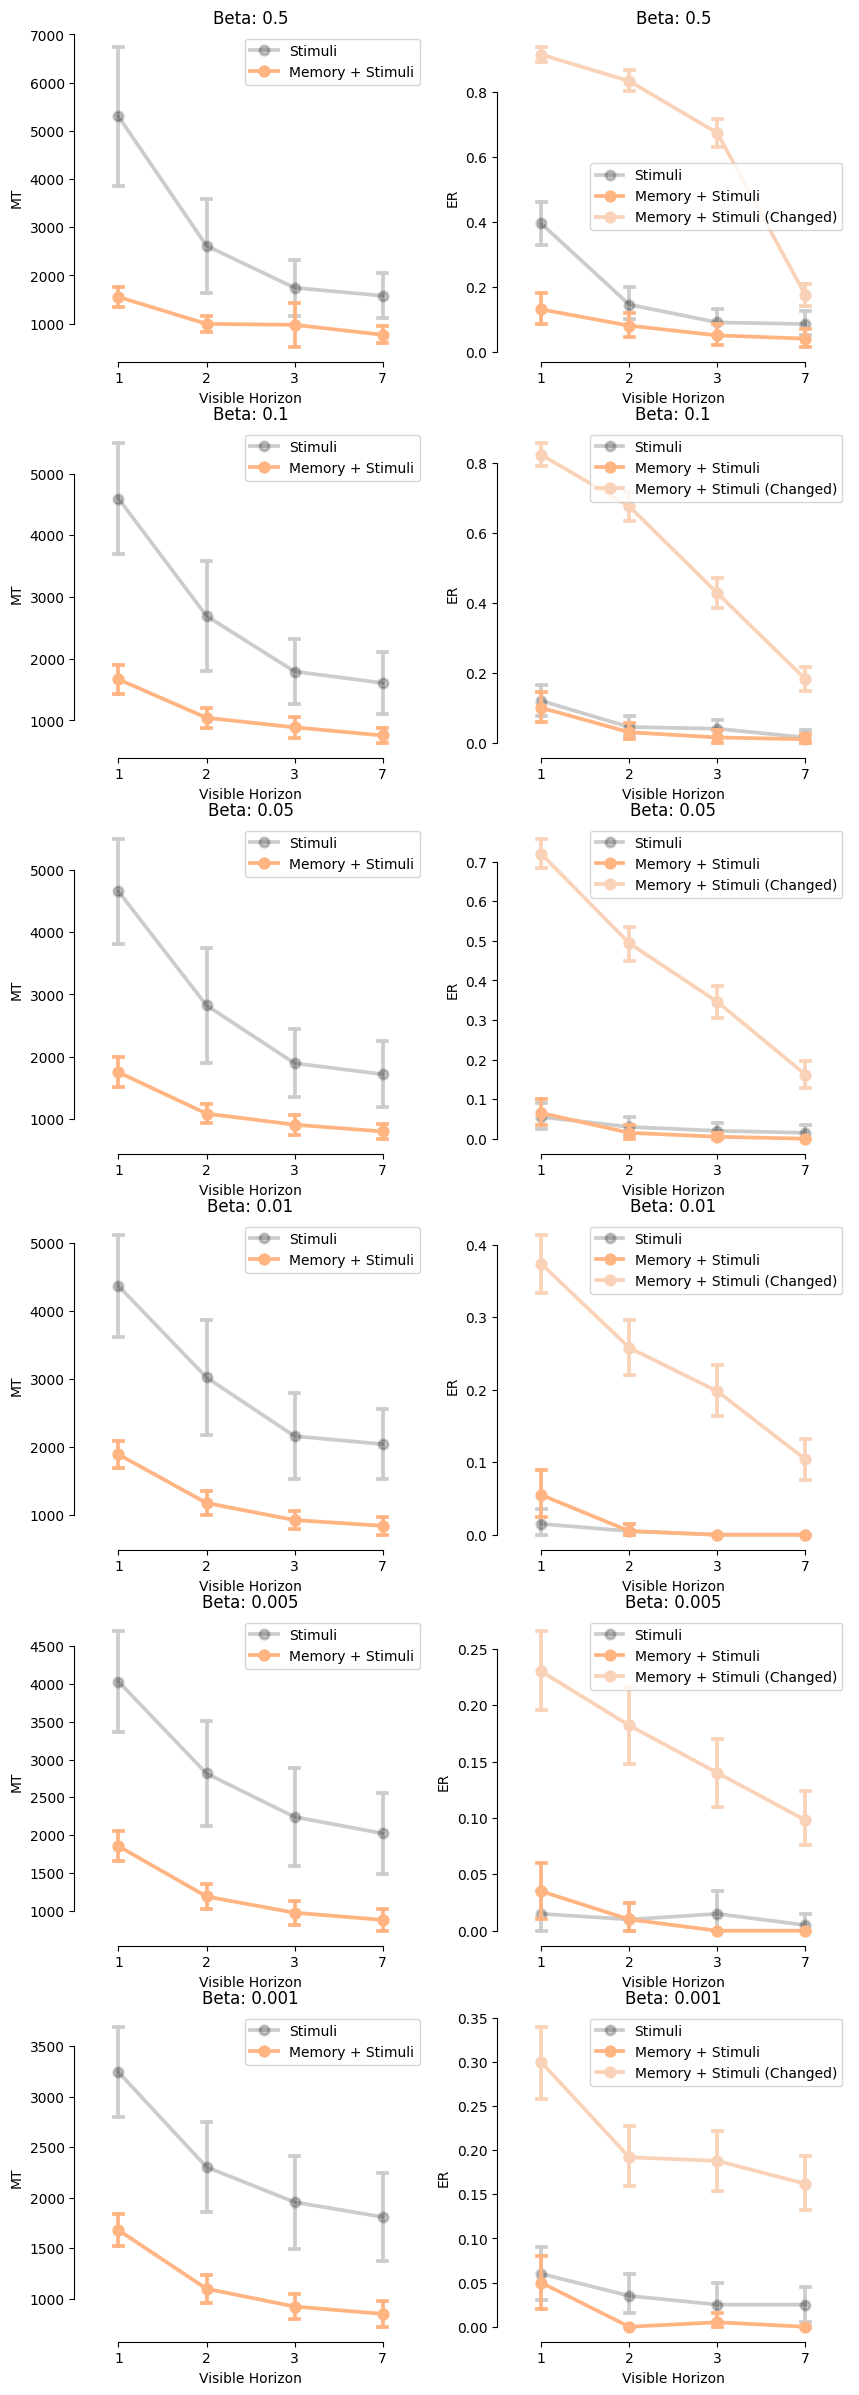

CPU times: user 2min 48s, sys: 347 ms, total: 2min 49s
Wall time: 2min 51s


In [975]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

betas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

fig, axs = plt.subplots(len(betas), 2, figsize = (10, 5 * len(betas)))



trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for plt_idx, beta in enumerate(betas):

    num_sims = 200

    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
            

    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param,alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'changed'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 500
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    # sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])

    for ax in axs[plt_idx]:
        ax.set_xlabel('Visible Horizon')
        ax.set_xticks(range(len(window_sizes)))
        ax.set_xticklabels(window_sizes)
        ax.set_title(f'Beta: {beta}')


# legend labels

plt.legend(loc='upper right')

sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


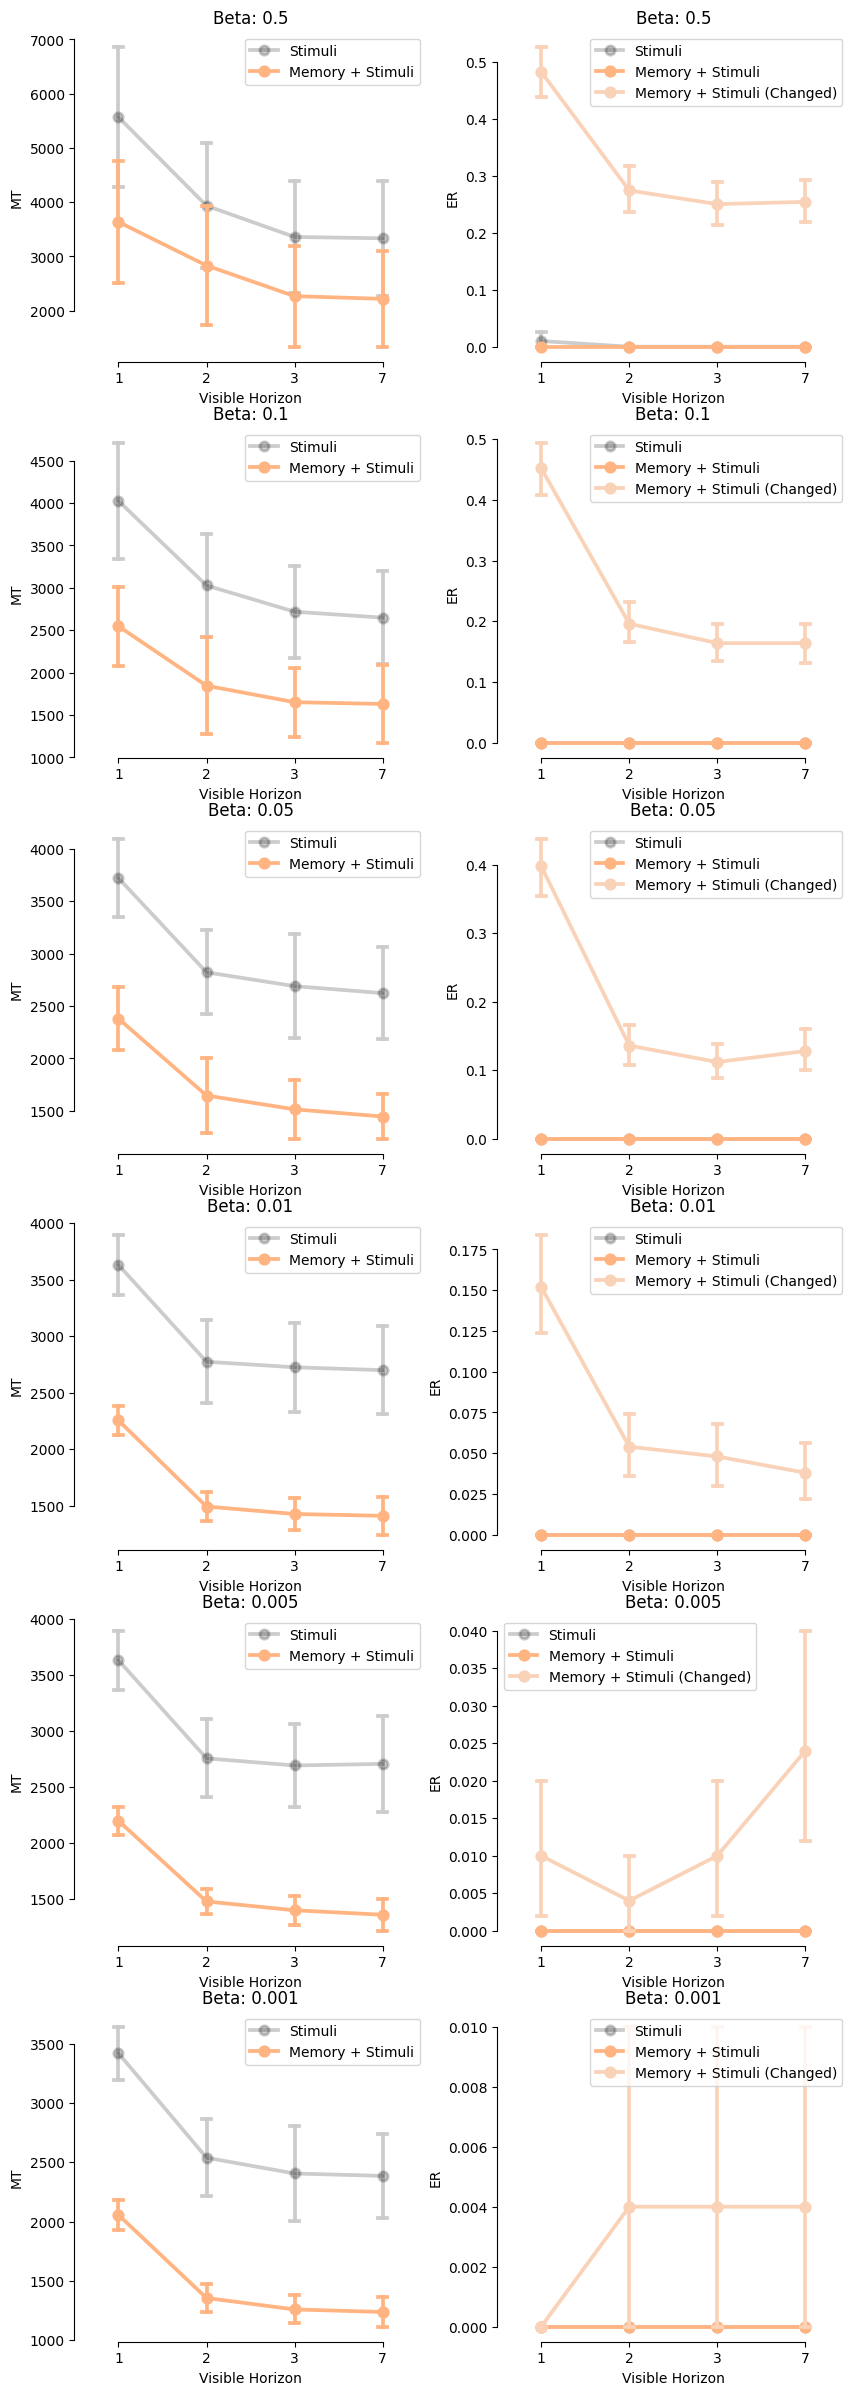

CPU times: user 3min 9s, sys: 2.39 s, total: 3min 11s
Wall time: 3min 12s


In [254]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

betas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

fig, axs = plt.subplots(len(betas), 2, figsize = (10, 5 * len(betas)))



trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for plt_idx, beta in enumerate(betas):

    num_sims = 200

    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
            

    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param,alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'changed'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 500
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    # sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])

    for ax in axs[plt_idx]:
        ax.set_xlabel('Visible Horizon')
        ax.set_xticks(range(len(window_sizes)))
        ax.set_xticklabels(window_sizes)
        ax.set_title(f'Beta: {beta}')


# legend labels

plt.legend(loc='upper right')

sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


# Testing for different alphas

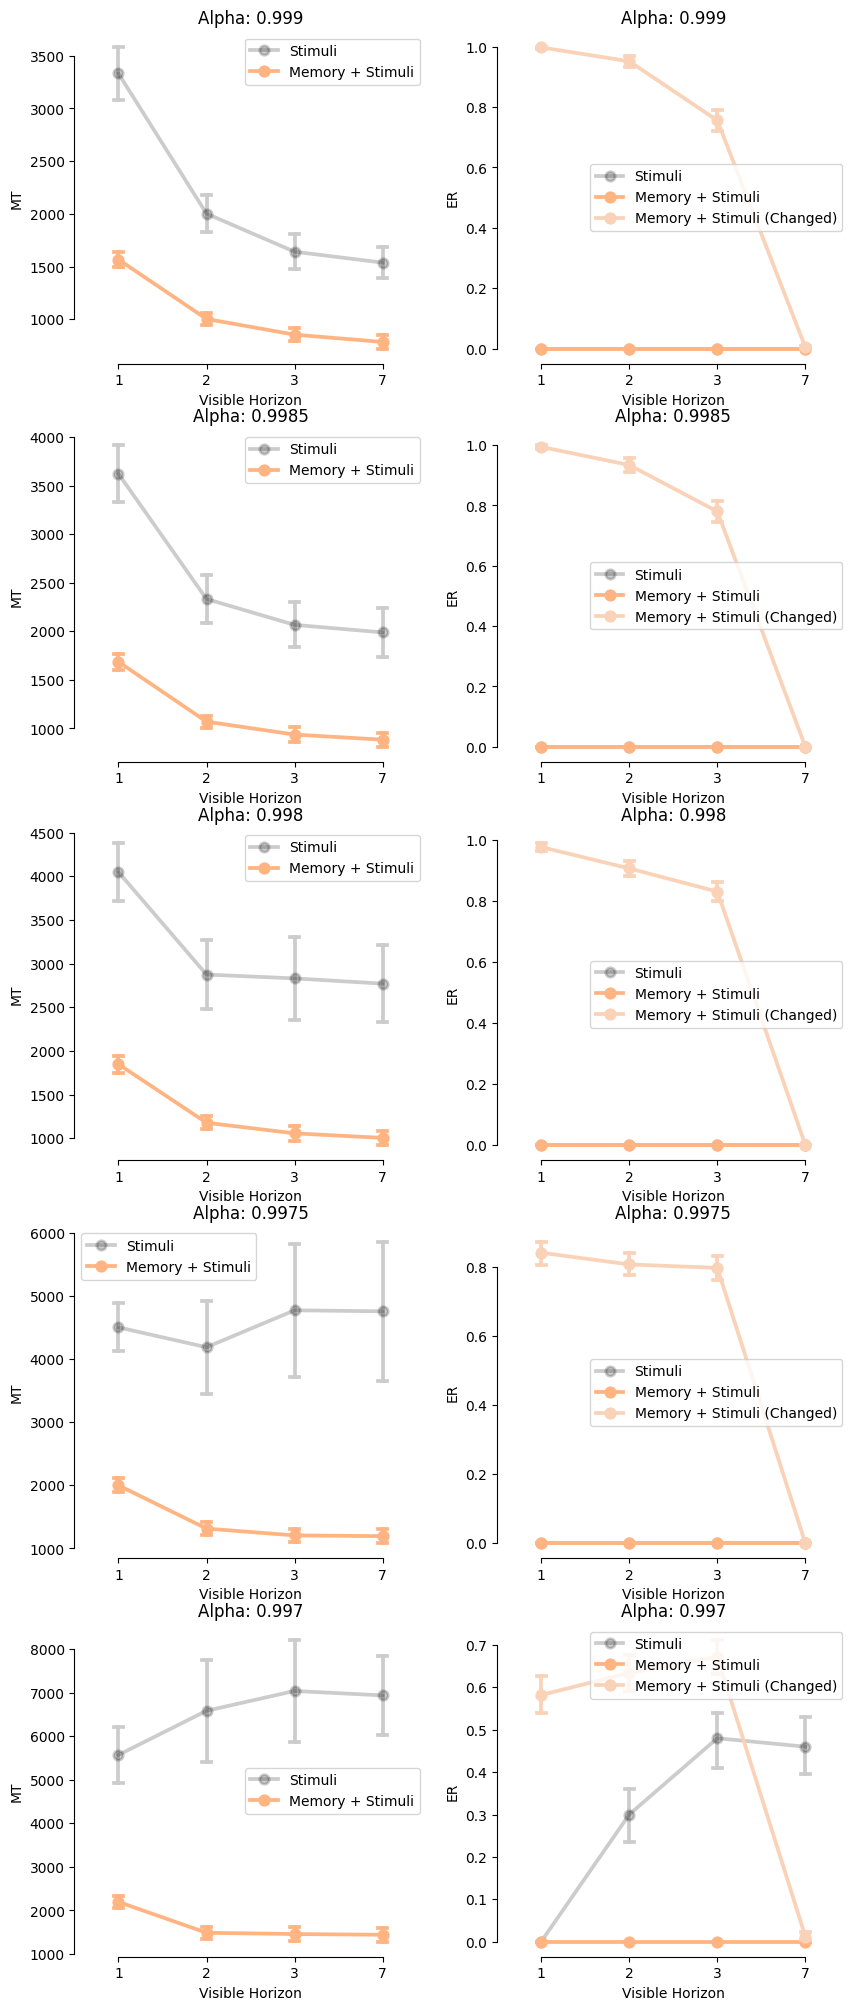

CPU times: user 2min 54s, sys: 262 ms, total: 2min 55s
Wall time: 2min 56s


In [977]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

beta = 0.03
# alpha = 0.9985


alphas = [0.999,0.9985, 0.998, 0.9975, 0.997]

fig, axs = plt.subplots(len(alphas), 2, figsize = (10, 5 * len(alphas)))



trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

for plt_idx, alpha in enumerate(alphas):

    num_sims = 200

    visual_drifts = calc_visual_drifts(random_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'rand'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
        diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
        planning_param=param, motor_planning_param = motor_planning_param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, random_seq)]
            if check_evidence_to_seq(evidence, random_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]
            

    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'unchanged'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 200
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param,alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]


    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])
    sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 0])


    visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    label = 'changed'
    MT = pd.DataFrame(columns = ['windowSize', 'MT'])
    ER = pd.DataFrame(columns = ['windowSize', 'ER'])
    num_sims = 500
    for window in window_sizes:
        model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion, 
        threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
        motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
        seq_length = seq_length, memory_drift_coef = memory_drift_coef)
        for _ in range(num_sims):
            IPIs, evidence = model.simulate()
            ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
            if check_evidence_to_seq(evidence, specific_seq):
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

    # sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[0])
    sns.pointplot(data=ER, x='windowSize', y='ER', dodge=True, label = 'Memory + Stimuli (Changed)', capsize=0.1, **kwargs[label], ax = axs[plt_idx, 1])

    for ax in axs[plt_idx]:
        ax.set_xlabel('Visible Horizon')
        ax.set_xticks(range(len(window_sizes)))
        ax.set_xticklabels(window_sizes)
        ax.set_title(f'Alpha: {alpha}') 



# legend labels

plt.legend(loc='upper right')

sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


## Trial Examples:

****** Window Size:  3  ******
436.0
670.0
784.0
1958.0


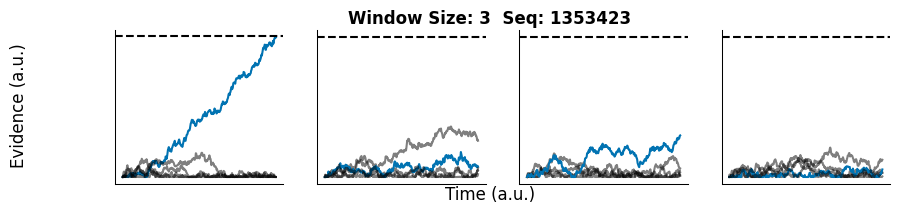

In [ ]:
# alpha = 0.9985
# beta = 0.03
set_figure_style("1.5col")
visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
for window in window_sizes:
    if window != 3:
        continue
    print("****** Window Size: ", window, " ******")
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, 
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    fig , axs = model.plot_simulations()
    fig.suptitle(f'Window Size: {window}  Seq: {specific_seq_changed_one_digit}')

    for ax in axs:
        # ax.set_ylim([0, 100])
        ax.set_yticks([])
        ax.set_xticks([])
    
    #common legend
    # handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right')

    sns.despine(trim=True)

    # for _ in range(num_sims):
    #     IPIs, evidence = model.simulate()
    #     ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
    #     if check_evidence_to_seq(evidence, specific_seq):
    #         MT.loc[len(MT)] = [window, sum(IPIs[1:])]

plt.savefig(path_figs + "HorizonTrialsExample.pdf", format = 'pdf', bbox_inches = 'tight')

In [11]:
specific_seq
# specific_seq_changed_one_digit

'1352423'

****** Window Size:  1  ******
changed digit:  3
****** Window Size:  2  ******
changed digit:  3
****** Window Size:  3  ******
changed digit:  3
****** Window Size:  7  ******
changed digit:  3


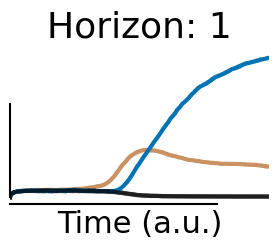

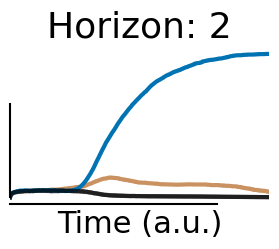

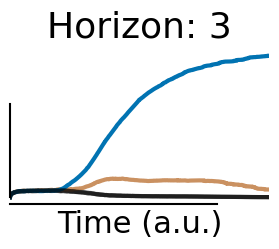

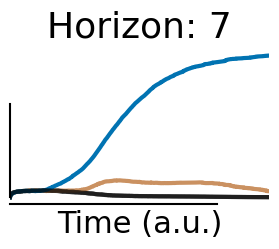

In [39]:
# alpha = 0.9985
# beta = 0.05
set_figure_style("1col")
visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'changed'
for window in window_sizes:
    plt.figure()
    print("****** Window Size: ", window, " ******")
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, 
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    motor_planning_param = motor_planning_param ,alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    # fig, axs = model.plot_average_simulations(1)
    model.plot_average_simulations(1000)
    plt.xlim([0, 2500])
    # fig.suptitle(f'Window Size: {window}  Seq: {specific_seq_changed_one_digit}')

    # for ax in axs:
    #     ax.set_ylim([0, 100])
    
    # #common legend
    # handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right')

    sns.despine(trim=True)
    plt.yticks([])
    plt.xticks([])
    plt.title(f'Horizon: {window}')
    plt.savefig(path_figs + f"Competition_H{window}.pdf", format = 'pdf', bbox_inches = 'tight')

    # for _ in range(num_sims):
    #     IPIs, evidence = model.simulate()
    #     ER.loc[len(ER)] = [window, 1 - check_evidence_to_seq(evidence, specific_seq_changed_one_digit)]
    #     if check_evidence_to_seq(evidence, specific_seq):
    #         MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# Second Experiment

In [11]:
seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'


seq_length = len(seq)
window_sizes = [2,3,4,11]


visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)


visual_delay = 90
motor_delay = 50

diffusion = 3
threshold = 310
alpha = 0.9985
# alpha = 0.9987
# alpha = 0.999
# beta = 0.0005
# beta = 0.001
# beta = 0.0001
# beta = 0
# beta = 0.0015
beta = 0.005

# param = [0.80456878, 0.36385731, 0.75921864, 0.36382248, 0.17006857,
#        0.72666298, 0.36340774, 0.16293408, 0.07705195]


# param = [0.81403939, 0.39269762, 0.78576587, 0.39263559, 0.1590846 ,
#        0.78171855, 0.39182347, 0.13888817, 0.05866263]


# param = [0.80546286, 0.34406671, 0.77078511, 0.34047097, 0.17400204,
#        0.76927114, 0.33807873, 0.16315422, 0.08028436]


# param = [0.75295921, 0.50182646, 0.73406735, 0.45987093, 0.34447993,
#         0.69723121, 0.41742494, 0.2493258 , 0.24174475]


param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]


# motor_planning_param = [0.54899844, 0.3728446 , 0.32852511]
# motor_planning_param = [0.7527961,  0.78437558, 0.16115195]
motor_planning_param = [0.78642621, 0.78482953, 0.16115546]
# motor_planning_param = [0.7, 0.69, 0.3]
# motor_planning_param = [0.7, 0.6, 0.3]
# motor_planning_param = [0.7, 0.5, 0.3]
# motor_planning_param = [0.7, 0.49, 0.29]
# motor_planning_param = [0.7, 0.47, 0.33]
# motor_planning_param = [0.7, 0.45, 0.35]
# motor_planning_param = [0.7, 0.1, 0.4]
# motor_planning_param [ 0.7, 1, 0, 0]

In [12]:
visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.3
memory_drift_adaptive_coef = 0
visual_drift_adaptive_coef = 0
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9
memory_drift_adaptive_coef_activation = 0
memory_drift_adaptive_coef_deactivation = 0

<timed exec>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df            F         PR(>F)
C(windowSize)               7.592953e+07     3.0   311.208469  5.603841e-159
C(condition)                5.259248e+08     1.0  6466.742910   0.000000e+00
C(windowSize):C(condition)  2.225179e+06     3.0     9.120227   5.511290e-06
Residual                    1.294736e+08  1592.0          NaN            NaN
                            MT
condition windowSize          
M+S       2.0         3024.550
          3.0         2711.305
          4.0         2572.215
          11.0        2580.570
S         2.0         4295.750
          3.0         3817.850
          4.0         3704.630
          11.0        3657.020


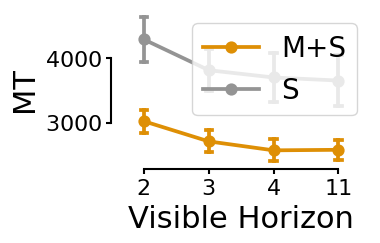

CPU times: user 19.2 s, sys: 1.91 s, total: 21.1 s
Wall time: 19.3 s


In [14]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'M+S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, color = custom_palette[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'S'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, color = custom_palette[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




# visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# MT = pd.DataFrame(columns = ['windowSize', 'MT'])
# label = '
# for window in window_sizes:
#     model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
#     diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
#     planning_param=param, motor_planning_param = motor_planning_param, 
#     alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
#     for _ in range(num_sims):
#         IPIs, evidence = model.simulate()
#         MT.loc[len(MT)] = [window, sum(IPIs[1:])]

# sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print(ANOVA_data.groupby(['condition', 'windowSize']).agg({'MT': 'mean'}))


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
# handles, _ = plt.gca().get_legend_handles_labels()
# labels = ['Trained', 'Random', 'Trained Changed']
# plt.legend(handles, labels, loc='upper right')
plt.legend(loc = 'upper right')

# plt.legend()
sns.despine(trim=True)
plt.savefig(path_figs + "MT_model_digit_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


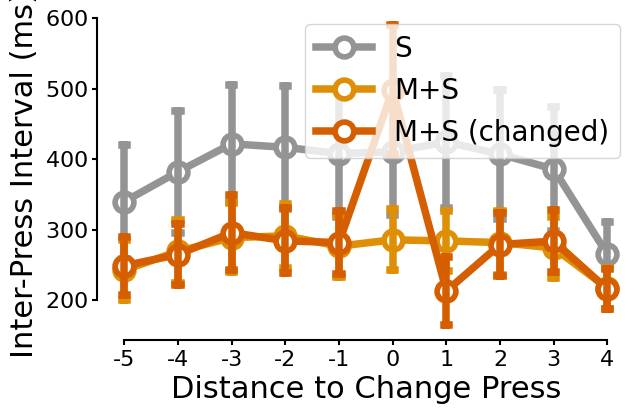

In [70]:
set_figure_style(scale = "2col")
lookback_window = 6
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 500

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'S'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            motor_planning_param= motor_planning_param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color= custom_palette[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'M+S'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              motor_planning_param= motor_planning_param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color = custom_palette[label])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'M+S (changed)'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
             motor_planning_param= motor_planning_param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color= custom_palette[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Inter-Press Interval (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')


for artist in plt.gcf().findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('white')


sns.despine(trim=True)

# legend labels

plt.savefig(path_figs + "Perturbation_digit_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


In [16]:
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 1

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_80634/2296344781.py:47: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]


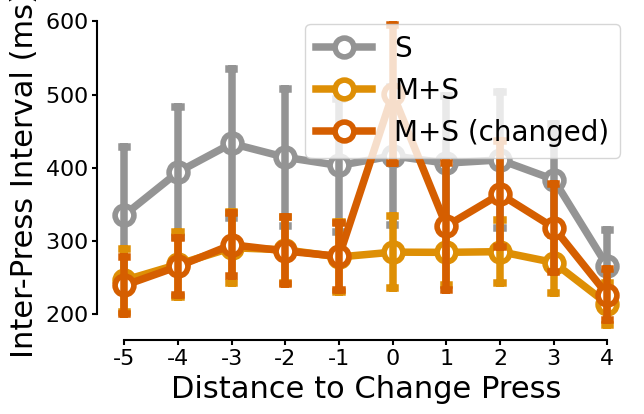

In [17]:
lookback_window = 6
change_idx = 6

set_figure_style("2col")

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 500

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'S'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            motor_planning_param= motor_planning_param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color= custom_palette[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'M+S'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              motor_planning_param= motor_planning_param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color = custom_palette[label])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'M+S (changed)'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
             motor_planning_param= motor_planning_param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color= custom_palette[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Inter-Press Interval (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')

for artist in plt.gcf().findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('white')

sns.despine(trim=True)

# legend labels

plt.savefig(path_figs + "Perturbation_digit_activation_deactivation_fitting.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


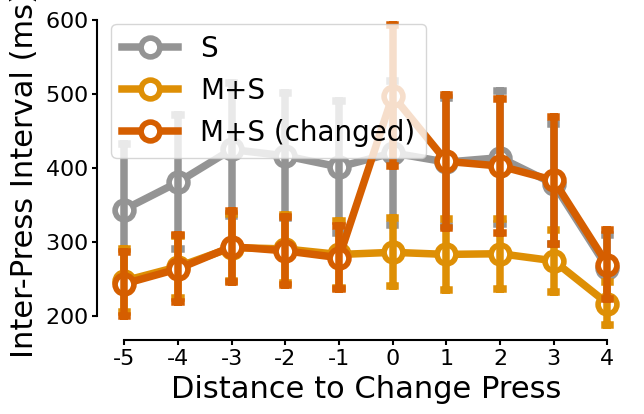

In [18]:
set_figure_style("2col")

lookback_window = 6
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 500

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'S'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            motor_planning_param= motor_planning_param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color= custom_palette[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'M+S'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              motor_planning_param= motor_planning_param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color = custom_palette[label])



visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'M+S (changed)'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
             motor_planning_param= motor_planning_param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()
IPI['dist_to_change'] = IPI['dist_to_change'].astype(int)

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, color= custom_palette[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Inter-Press Interval (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')

for artist in plt.gcf().findobj(match=plt.Line2D):
    if artist.get_marker() != 'None':
        artist.set_markerfacecolor('white')
        
sns.despine(trim=True)

# legend labels

plt.savefig(path_figs + "Perturbation_activation_deactivation_prediction.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


In [103]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

deactivation_speed: slow, activation_speed: slow, memory_states: [1, 0.6, 0.76, 0.856, 0.9136, 0.94816, 0.968896, 0.9813376, 0.98880256, 0.993281536, 0.9959689216000001, 0.9975813529600001]
deactivation_speed: slow, activation_speed: fast, memory_states: [1, 0.6, 0.96, 0.996, 0.9996, 0.99996, 0.999996, 0.9999996, 0.99999996, 0.999999996, 0.9999999996, 0.99999999996]
deactivation_speed: fast, activation_speed: slow, memory_states: [1, 0.09999999999999998, 0.46, 0.676, 0.8056000000000001, 0.88336, 0.9300160000000001, 0.9580096, 0.97480576, 0.9848834559999999, 0.9909300736, 0.9945580441599999]
deactivation_speed: fast, activation_speed: fast, memory_states: [1, 0.09999999999999998, 0.91, 0.991, 0.9991, 0.99991, 0.999991, 0.9999991, 0.99999991, 0.999999991, 0.9999999991, 0.99999999991]


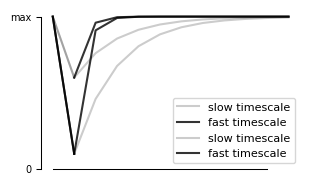

In [ ]:
# figure showing how memory coef changes with adaptive coef
import itertools

upper_bound = 1
lower_bound = 0
time_constant_fast = 0.9
time_constant_slow = 0.4
time_constant_states = ['slow', 'fast']
time_constants = {'slow': time_constant_slow, 'fast': time_constant_fast}

for idx, (deactivation_speed, activation_speed) in enumerate(itertools.product(time_constant_states, repeat=2)):
    time_constant_deactive = time_constants[deactivation_speed]
    time_constant_active = time_constants[activation_speed]

    current_memory = 1
    memory_states = [current_memory, current_memory]

    #deactivation_step 
    current_memory = current_memory * (1 - time_constant_deactive)
    memory_states.append(current_memory)

    #activation_steps
    for _ in range(10):
        current_memory = time_constant_active + (upper_bound - time_constant_active) * current_memory
        memory_states.append(current_memory)

    print(f"deactivation_speed: {deactivation_speed}, activation_speed: {activation_speed}, memory_states: {memory_states}")
    # sns.pointplot(x = np.array(range(len(memory_states))), y = memory_states, color = 'black')
    if deactivation_speed == 'slow':
        alpha = 0.2
        label = 'slow timescale'
    if deactivation_speed == 'fast':
        alpha = 0.8
        label = 'fast timescale'
    sns.lineplot(x = np.array(range(len(memory_states)))[:2] , y = memory_states[:2], color = 'black', alpha = alpha)

    if activation_speed == 'slow':
        alpha = 0.2
        label = 'slow timescale'
    if activation_speed == 'fast':
        alpha = 0.8
        label = 'fast timescale'
    sns.lineplot(x = np.array(range(len(memory_states)))[1:] , y = memory_states[1:], color = 'black', alpha = alpha, label = label)
    

    

# decaying_coefs = [ (1 - time_constant_deactive) ** i for i in range(0,10)]
# growing_coefs = [1 - (1 - time_constant_active) ** i for i in range(0,10)]

# sns.pointplot(x = range(10), y = decaying_coefs, color = 'black')
# sns.pointplot(x = range(10), y = growing_coefs, color = 'black')
plt.yticks([0, 1], ['0', 'max'])
sns.despine(trim=True)
plt.xticks([], [])
plt.savefig(path_figs + "activation_deactivation_time_constants.pdf", format = 'pdf', bbox_inches = 'tight')